# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 使用葉編碼並觀察預測效果

# [作業重點]
- 仿造範例, 完成葉編碼的寫作 : 使用隨機森林 (In[3], Out[3], In[4], Out[4])
- 仿造範例, 觀察葉編碼搭配邏輯斯迴歸後的效果 (In[5], Out[5], In[6], Out[6]) 

In [52]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# 因為擬合(fit)與編碼(transform)需要分開, 因此不使用.get_dummy, 而採用 sklearn 的 OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

data_path = 'D:/GitHub/Data/Data1/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [53]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

C:\Users\awei.lin\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [54]:
train_X = df.values
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練及切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果

# 切出兩種資料集的方法train_test_split
# 1. TranX, TestX
# 2. TranX, ValX
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5)

# 作業1
* 請對照範例，完成隨機森林的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸

In [55]:
# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸

# n_estimators : 幾棵樹
# min_samples_split : 这个值限制了子树继续划分的条件，如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分。 
#                     默认是2.如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。

# min_samples_leaf : 这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝。 默认是1,可以输入最少的样本数的整数
#                   ，或者最少样本数占样本总数的百分比。如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。

# max_features : 單棵決策數使用的最多特徵數量
# max_depth : 數的最大深度
# bootstrap : 是否放回抽樣

rf = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5, 
                            max_features=4, max_depth=3, bootstrap=True)
onehot = OneHotEncoder()

lr = LogisticRegression(solver='lbfgs', max_iter=1000)

"""
Your Code Here (Hint : 隨機森林的葉編碼(.apply)不需要加上[:, :, 0], 直接用rf.apply()調用即可, 本作業其餘寫法相同)
"""
#隨機森林擬合
rf.fit(train_X, train_Y)

#葉編碼 (*.apply) 做獨熱
onehot.fit(rf.apply(train_X))

#邏輯斯迴歸
lr.fit(onehot.transform(rf.apply(val_X)), val_Y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
# 將隨機森林+葉編碼+邏輯斯迴歸結果輸出
"""
Your Code Here 
"""
from sklearn.model_selection import cross_val_score

# 真陽性率 (TPR, true positive rate)
# 又稱：命中率 (hit rate)、敏感度(sensitivity)
# TPR = TP / P = TP / (TP+FN)
# 偽陽性率(FPR, false positive rate)
# 又稱：錯誤命中率，假警報率 (false alarm rate)
# FPR = FP / N = FP / (FP + TN)

pred_rf_lr = lr.predict_proba(onehot.transform(rf.apply(test_X)))[:, 1]
fpr_rf_lr, tpr_rf_lr, _ = roc_curve(test_Y, pred_rf_lr)

print(cross_val_score(lr, onehot.transform(rf.apply(val_X)), val_Y, cv=5).mean())



0.811963109354


In [68]:
type(pred_rf_lr)

numpy.ndarray

In [58]:
# 將隨機森林結果輸出
"""
Your Code Here """

pred_rf = rf.predict_proba(test_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test_Y, pred_rf)

print(cross_val_score(rf, train_X, train_Y, cv=5).mean())


0.819494949495


# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?

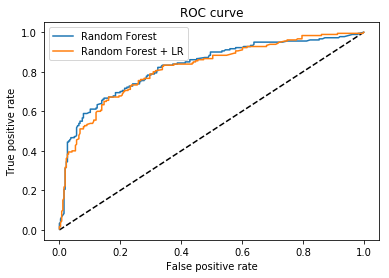

In [63]:
import matplotlib.pyplot as plt
# 將結果繪圖
# https://zh.wikipedia.org/wiki/ROC%E6%9B%B2%E7%BA%BF

## X Y範圍控制 0~1之間
plt.plot([0, 1], [0, 1], 'k--')

## 畫線條A
plt.plot(fpr_rf, tpr_rf, label='Random Forest')

## 畫線條B
plt.plot(fpr_rf_lr, tpr_rf_lr, label='Random Forest + LR')

## X軸名稱
plt.xlabel('False positive rate')

## Y軸名稱
plt.ylabel('True positive rate')

## Plot名稱
plt.title('ROC curve')

## 圖中框框位置
plt.legend(loc='best')

plt.show()

# 準確度 (ACC, accuracy)
# ACC = (TP + TN) / (P + N)
# 即：(真陽性+真陰性) / 總樣本數

# ROC 曲線，越靠近左上角的預測越準，越靠近右下角的鏡像預測也越準

In [60]:
# Over-fitting
# 過擬合代表模型可能學習到資料中的噪⾳音，導致在實際應⽤用時預測失準